# VAE Implementation Workbook

Build, train, and test the variational autoencoder; visualize and quantify its results.

In [2]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os
import glob
import pandas as pd
import random
import numpy as np
import imageio
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
from scipy.stats import norm

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import backend
from keras import layers, Input, Model, ops

import seaborn as sns
import pickle

# Loading the data

We take the pickle file (`.pkl`) containing the images (in this workbook, from the A1 tile) and the `csv` file containing the redshifts.

In [5]:
DATA_PATH = "A1_compiled_cutouts_3arcsec_30mas.pkl"

In [6]:
# Load data
# rows: ID, image info
with open(DATA_PATH, "rb") as f:
    data = pickle.load(f) 

In [7]:
# IDs
ids = data[0]

# images
images = np.stack(data[1]).astype("float32")
print(np.min(images))
images = np.log10(images - np.min(images)+0.01)
print(np.max(images))
images = images / np.max(images)  # normalize

-0.95650524
2.72259


Match and merge the datasets based on the object's ID.

In [9]:
attrs = pd.read_csv("cosmos_cut.csv", sep=",")

df_images = pd.DataFrame({'id': ids})
df_merged = pd.merge(df_images, attrs, on="id", how="inner") # only when IDs match

images = images[df_merged.index]
redshifts = df_merged["z"].to_numpy(dtype="float32")
redshifts = redshifts / np.max(redshifts)

## Constructing the autoencoder

The encoder part of the VAE architecture maps a data point to a variational mean and (log) variance. The mean is a point in the latent space.


In [11]:
LATENT_SPACE_SIZE = 100

The "reparameterization trick" draws samples from the variational distribution that are parameterized by the variational mean and variance, so that the parameters of the encoder network can be trained.


In [13]:
def sample_latent_features(distribution):
    distribution_mean, distribution_variance = distribution
    batch_size = tf.shape(distribution_variance)[0]
    noise = backend.random_normal(shape=(batch_size, tf.shape(distribution_variance)[1]))
    return distribution_mean + tf.exp(0.5 * distribution_variance) * noise

In [64]:
LATENT_DIM = 100

# ---- Inputs
img_in = layers.Input(shape=(100, 100, 4), name="image")
z_in   = layers.Input(shape=(1,),          name="redshift")

# ---- Image branch
x = layers.Conv2D(64, 5, padding="same", activation="relu")(img_in)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)
x = layers.MaxPool2D()(x)
x = layers.Flatten()(x)

# ---- Concatenate image features + redshift
hg = layers.Dense(512, activation="relu")(z_in)
h = layers.Concatenate()([x, hg])
#h = layers.Dense(512, activation="relu")(h)

# ---- Latent parameters
z_mean = layers.Dense(LATENT_DIM, name="z_mean")(h)
z_logv = layers.Dense(LATENT_DIM, name="z_logvar")(h)

# ---- Sampling layer that ALSO adds KL via add_loss
class Sampling(layers.Layer):
    def __init__(self, beta=1.0, **kwargs):
        super().__init__(**kwargs)
        self.beta = beta

    def build(self, input_shape):
        self.rng = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        mean, logvar = inputs
        eps = keras.random.normal(shape=ops.shape(mean),
                                  dtype=mean.dtype,
                                  seed=self.rng)
        z = mean + ops.exp(0.5 * logvar) * eps

        # KL per sample
        kl_per_sample = -0.5 * ops.sum(
            1 + logvar - ops.square(mean) - ops.exp(logvar), axis=-1
        )
        # Apply weighting factor (β-VAE trick)
        self.add_loss(self.beta * ops.mean(kl_per_sample))
        return z

z_latent = Sampling(beta=0.5, name="z")([z_mean, z_logv])

# ---- Decoder (hybrid upsampling + convolution)
# input is the latent space from the encoder
d = layers.Dense(12 * 12 * 64, activation="relu")(z_latent)
d = layers.Reshape((12, 12, 64))(d)  # start from 12x12

# 12 -> 24
d = layers.UpSampling2D(size=2, interpolation="bilinear")(d)
d = layers.Conv2D(64, 3, padding="same", activation="relu")(d)

# 24 -> 48
d = layers.UpSampling2D(size=2, interpolation="bilinear")(d)
d = layers.Conv2D(64, 3, padding="same", activation="relu")(d)

# 48 -> 96
d = layers.UpSampling2D(size=2, interpolation="bilinear")(d)
d = layers.Conv2D(32, 3, padding="same", activation="relu")(d)

# Final adjustment: 96 -> 100 (adjust for integer division during convolution)
d = layers.Resizing(100, 100, interpolation="bilinear")(d)

# Output reconstruction (linear activation since it's regression)
x_recon = layers.Conv2D(4, 3, padding="same", activation="linear", name="image_recon")(d)

# ---- Optional small head to reconstruct the scalar redshift as an auxiliary target
z_hat = layers.Dense(32, activation="relu")(z_latent)
z_hat = layers.Dense(1,  activation="linear", name="z_recon")(z_hat)

autoencoder = keras.Model(inputs=[img_in, z_in], outputs=[x_recon, z_hat], name="vae")

# Only reconstruction losses go in compile. The KL is already attached via add_loss.
autoencoder.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss={"image_recon": "mse", "z_recon": "mse"},
    loss_weights={"image_recon": 1000.0, "z_recon": 1.0},)

The VAE model has two main components to its loss function: the reconstruction loss (how well the decoder rebuilds the input features from the latent embeddings) and the KL-divergence loss (how much the encoder's latent distribution deviates from the target prior, usually a standard Gaussian which forces a smooth and continuous latent space). In our architecture, the KL loss was downweighted to prioritize reconstruction accuracy. 

In addition, the image reconstruction is weighted considerably higher in the loss function than the redshift reconstruction, as it is easier to minimize loss on one scalar than 100x100 pixels. 

In [18]:
autoencoder.summary()

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 100, 100,  │          0 │ -                 │
│                     │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 100, 100,  │      6,464 │ image[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 50, 50,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 50, 50,    │     36,928 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 25, 25,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 25, 25,    │     18,464 │ max_pooling2d_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 12, 12,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ redshift            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 4608)      │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │      1,024 │ redshift[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 5120)      │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 100)       │    512,100 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_logvar (Dense)    │ (None, 100)       │    512,100 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Sampling)        │ (None, 100)       │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_logvar[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 9216)      │    930,816 │ z[0][0]           │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 12, 12,    │          0 │ dense_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 24, 24,    │          0 │ reshape[0][0]     │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 24, 24,    │     36,928 │ up_sampling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,114,637 (8.07 MB)

 Trainable params: 2,114,637 (8.07 MB)

 Non-trainable params: 0 (0.00 B)

# Train the autoencoder

In [20]:
# create training and validation sets
X_train, X_val, z_train, z_val = train_test_split(images, redshifts, test_size=0.2, random_state=365)

z_train = z_train.reshape(-1, 1)
z_val = z_val.reshape(-1, 1)

In [21]:
history = autoencoder.fit(
    [X_train, z_train],               # inputs: images + redshift
    [X_train, z_train],               # targets: reconstruct both
    epochs=3,                         # INCREASE EPOCH COUNT TO GET BETTER TRAINING
    batch_size=64,
    validation_data=([X_val, z_val], [X_val, z_val]))

Epoch 1/3
57/57 ━━━━━━━━━━━━━━━━━━━━ 172s 3s/step - image_recon_loss: 3.6800e-04 - loss: 0.9490 - z_recon_loss: 0.5512 - val_image_recon_loss: 2.9476e-05 - val_loss: 0.2792 - val_z_recon_loss: 0.2481
Epoch 2/3
57/57 ━━━━━━━━━━━━━━━━━━━━ 155s 3s/step - image_recon_loss: 2.3195e-05 - loss: 0.2530 - z_recon_loss: 0.2268 - val_image_recon_loss: 2.7102e-05 - val_loss: 0.2104 - val_z_recon_loss: 0.1889
Epoch 3/3
57/57 ━━━━━━━━━━━━━━━━━━━━ 184s 3s/step - image_recon_loss: 2.3602e-05 - loss: 0.1961 - z_recon_loss: 0.1709 - val_image_recon_loss: 2.6327e-05 - val_loss: 0.1635 - val_z_recon_loss: 0.1476


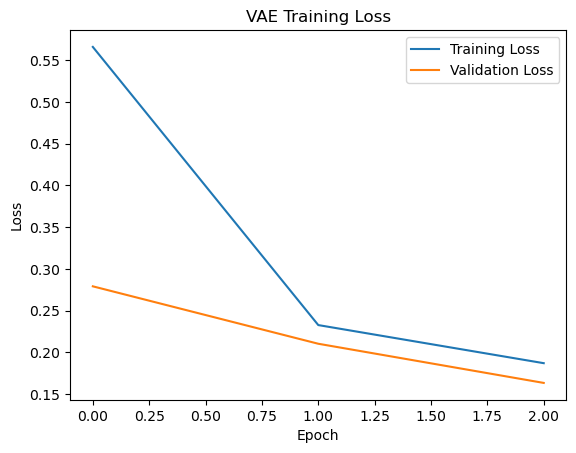

In [22]:
# plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE Training Loss')
plt.legend()
plt.show()

# Visualize samples

In [24]:
# helper functions
def _asinh_stretch(x, scale=None):
    """
    Asinh stretch commonly used for astro images.
    If scale is None, use a robust estimate based on the 90th percentile of |x|.
    """
    x = np.asarray(x)
    if scale is None:
        p = np.nanpercentile(np.abs(x), 90)
        scale = p if p > 0 else np.nanmax(np.abs(x)) + 1e-8
    return np.arcsinh(x / (scale + 1e-12))

def _auto_vmin_vmax(x, pct=(1, 99)):
    """Robust display limits from percentiles."""
    lo, hi = np.nanpercentile(x, pct[0]), np.nanpercentile(x, pct[1])
    if hi <= lo:  # fallback
        m, s = np.nanmean(x), np.nanstd(x)
        lo, hi = m - 2*s, m + 2*s
    return float(lo), float(hi)

def show_input_vs_output(
    model,
    X,
    z,
    idx=0,
    channel_names=None,
    stretch="asinh",      # 'asinh' or 'linear'
    percentiles=(1, 99),  # for linear scaling
    figsize=(12, 6),
    cmap="gray",
    show_residuals=True,
    print_redshift=True):
    """
    Visualize original vs reconstructed image for a single (image, redshift) pair.

    Parameters
    ----------
    model : keras.Model
        Your trained VAE model with outputs [image_recon, z_recon] or [image_recon].
    X : np.ndarray
        Image array of shape (N, H, W, C). (C should be 4 for your use case.)
    z : np.ndarray
        Redshift array of shape (N, 1) or (N,).
    idx : int
        Index of the sample to visualize.
    channel_names : list[str] or None
        Optional names for channels (e.g., ["F115W","F150W","F277W","F444W"]).
    stretch : {'asinh', 'linear'}
        Display stretch for visualization.
    percentiles : tuple(int,int)
        For 'linear' stretch, the (low, high) percentiles to set vmin/vmax.
    figsize : tuple
        Figure size.
    cmap : str
        Matplotlib colormap.
    show_residuals : bool
        If True, shows a third row with (recon - input).
    print_redshift : bool
        If True, prints the input redshift and predicted redshift (if available).

    Returns
    -------
    dict with keys:
        'x_true', 'x_recon', 'z_true', 'z_pred', 'residual'
    """

    # Prepare the specific sample
    x_true = X[idx]
    z_true = z[idx]
    if z_true.ndim == 0:        # scalar -> (1,)
        z_true = np.array([z_true], dtype=np.float32)
    if z_true.ndim == 1:        # (1,) -> (1,1) when batching
        z_true_b = z_true.reshape(1, 1)
    else:
        z_true_b = z_true.reshape(1, *z_true.shape)

    x_true_b = x_true[np.newaxis, ...]  # (1,H,W,C)

    # Forward pass
    pred = model.predict([x_true_b, z_true_b], verbose=0)
    if isinstance(pred, (list, tuple)):
        x_recon_b = pred[0]
        z_pred_b = pred[1] if len(pred) > 1 else None
    else:
        x_recon_b = pred
        z_pred_b = None

    x_recon = np.squeeze(x_recon_b, axis=0)  # (H,W,C)
    residual = x_recon - x_true

    # Print redshifts if desired
    if print_redshift:
        try:
            zt_scalar = float(z_true.ravel()[0])
        except Exception:
            zt_scalar = np.nan
        if z_pred_b is not None:
            zp_scalar = float(np.squeeze(z_pred_b))
            print(f"z_true = {zt_scalar:.5f} | z_pred = {zp_scalar:.5f}")
        else:
            print(f"z_true = {zt_scalar:.5f} | (model has no z_pred head)")

    H, W, C = x_true.shape
    cols = C
    rows = 3 if show_residuals else 2

    fig, axes = plt.subplots(rows, cols, figsize=figsize, constrained_layout=True)
    if rows == 1:
        axes = np.expand_dims(axes, 0)
    if cols == 1:
        axes = np.expand_dims(axes, 1)

    def format_title(base, c):
        if channel_names and c < len(channel_names):
            return f"{base} – {channel_names[c]}"
        return f"{base} – ch{c}"

    for c in range(C):
        # Choose scaling for each panel
        if stretch == "asinh":
            a_true = _asinh_stretch(x_true[..., c])
            a_reco = _asinh_stretch(x_recon[..., c])
            vmin_t, vmax_t = _auto_vmin_vmax(a_true)
            vmin_r, vmax_r = _auto_vmin_vmax(a_reco)
            # Keep separate vmin/vmax for truth vs recon to show structure clearly
            axes[0, c].imshow(a_true, cmap=cmap, vmin=vmin_t, vmax=vmax_t)
            axes[1, c].imshow(a_reco, cmap=cmap, vmin=vmin_r, vmax=vmax_r)
        else:  # linear
            vmin, vmax = _auto_vmin_vmax(x_true[..., c], percentiles)
            axes[0, c].imshow(x_true[..., c], cmap=cmap, vmin=vmin, vmax=vmax)
            axes[1, c].imshow(x_recon[..., c], cmap=cmap, vmin=vmin, vmax=vmax)

        axes[0, c].set_title(format_title("Input", c))
        axes[1, c].set_title(format_title("Reconstruction", c))
        axes[0, c].axis("off")
        axes[1, c].axis("off")

        if show_residuals:
            # Residuals in linear scale centered at 0 with symmetric range
            res = residual[..., c]
            m = np.nanmax(np.abs(res)) + 1e-12
            axes[2, c].imshow(res, cmap=cmap, vmin=-m, vmax=m)
            axes[2, c].set_title(format_title("Residual (recon - input)", c))
            axes[2, c].axis("off")

    plt.show()

    return {
        "x_true": x_true,
        "x_recon": x_recon,
        "z_true": z_true,
        "z_pred": None if z_pred_b is None else float(np.squeeze(z_pred_b)),
        "residual": residual,}

z_true = 0.39020 | z_pred = 0.27583


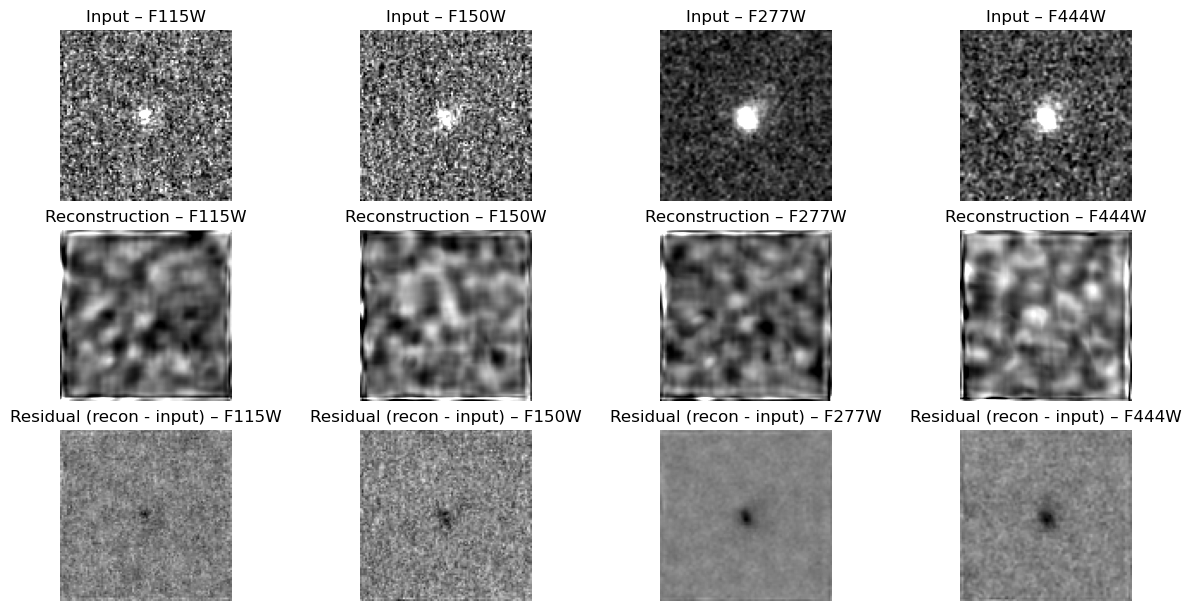

In [25]:
# Example channel labels for 4-band data:
chan_names = ["F115W", "F150W", "F277W", "F444W"]

# Show sample (change ID as desired)
_ = show_input_vs_output(
    autoencoder,
    X_train,
    z_train,
    idx=32,
    channel_names=chan_names,
    stretch="asinh",      
    show_residuals=True,
    cmap="gray",
)

**** note: make sure the redshift actually gets reconstructed ok. maybe i just trained it on too few epochs but it's inaccurate rn.
ok problem NOT solved after removing the decoder. shoot.

# Visualize the latent space

In [28]:
# build the encoder separately to extract the latent space
encoder = Model(inputs=[img_in, z_in], outputs=z_latent, name="encoder")

Since the latent space is set as 100 per the model architecture as specified before, we only select the most distinguishing dimensions to construct pairwise plots.

In [30]:
def LatentSpace_pairplot(encoder_model, images, labels, n_dims=10):
    # Encode all images to latent space
    z = encoder_model.predict(images, batch_size=64)
    
    # If latent space > n_dims, only take the first few for clarity
    z = z[:, :n_dims]
    
    # Build a dataframe
    df = pd.DataFrame(z, columns=[f"z{i+1}" for i in range(n_dims)])
    df["classification"] = labels

    # color and transparency maps
    label_to_color = {"LRD": "red", "Galaxy": "dodgerblue", "AGN": "mediumseagreen"}
    label_to_alpha = {"LRD": 1.0, "Galaxy": 0.15, "AGN": 0.45}

    # Plot
    sns.pairplot(df, hue="classification", palette=label_to_color, plot_kws={'alpha':0.4, 's':20})
    plt.suptitle("Latent Space Pairplot by Classification", y=1.02)
    plt.show()

71/71 ━━━━━━━━━━━━━━━━━━━━ 16s 223ms/step


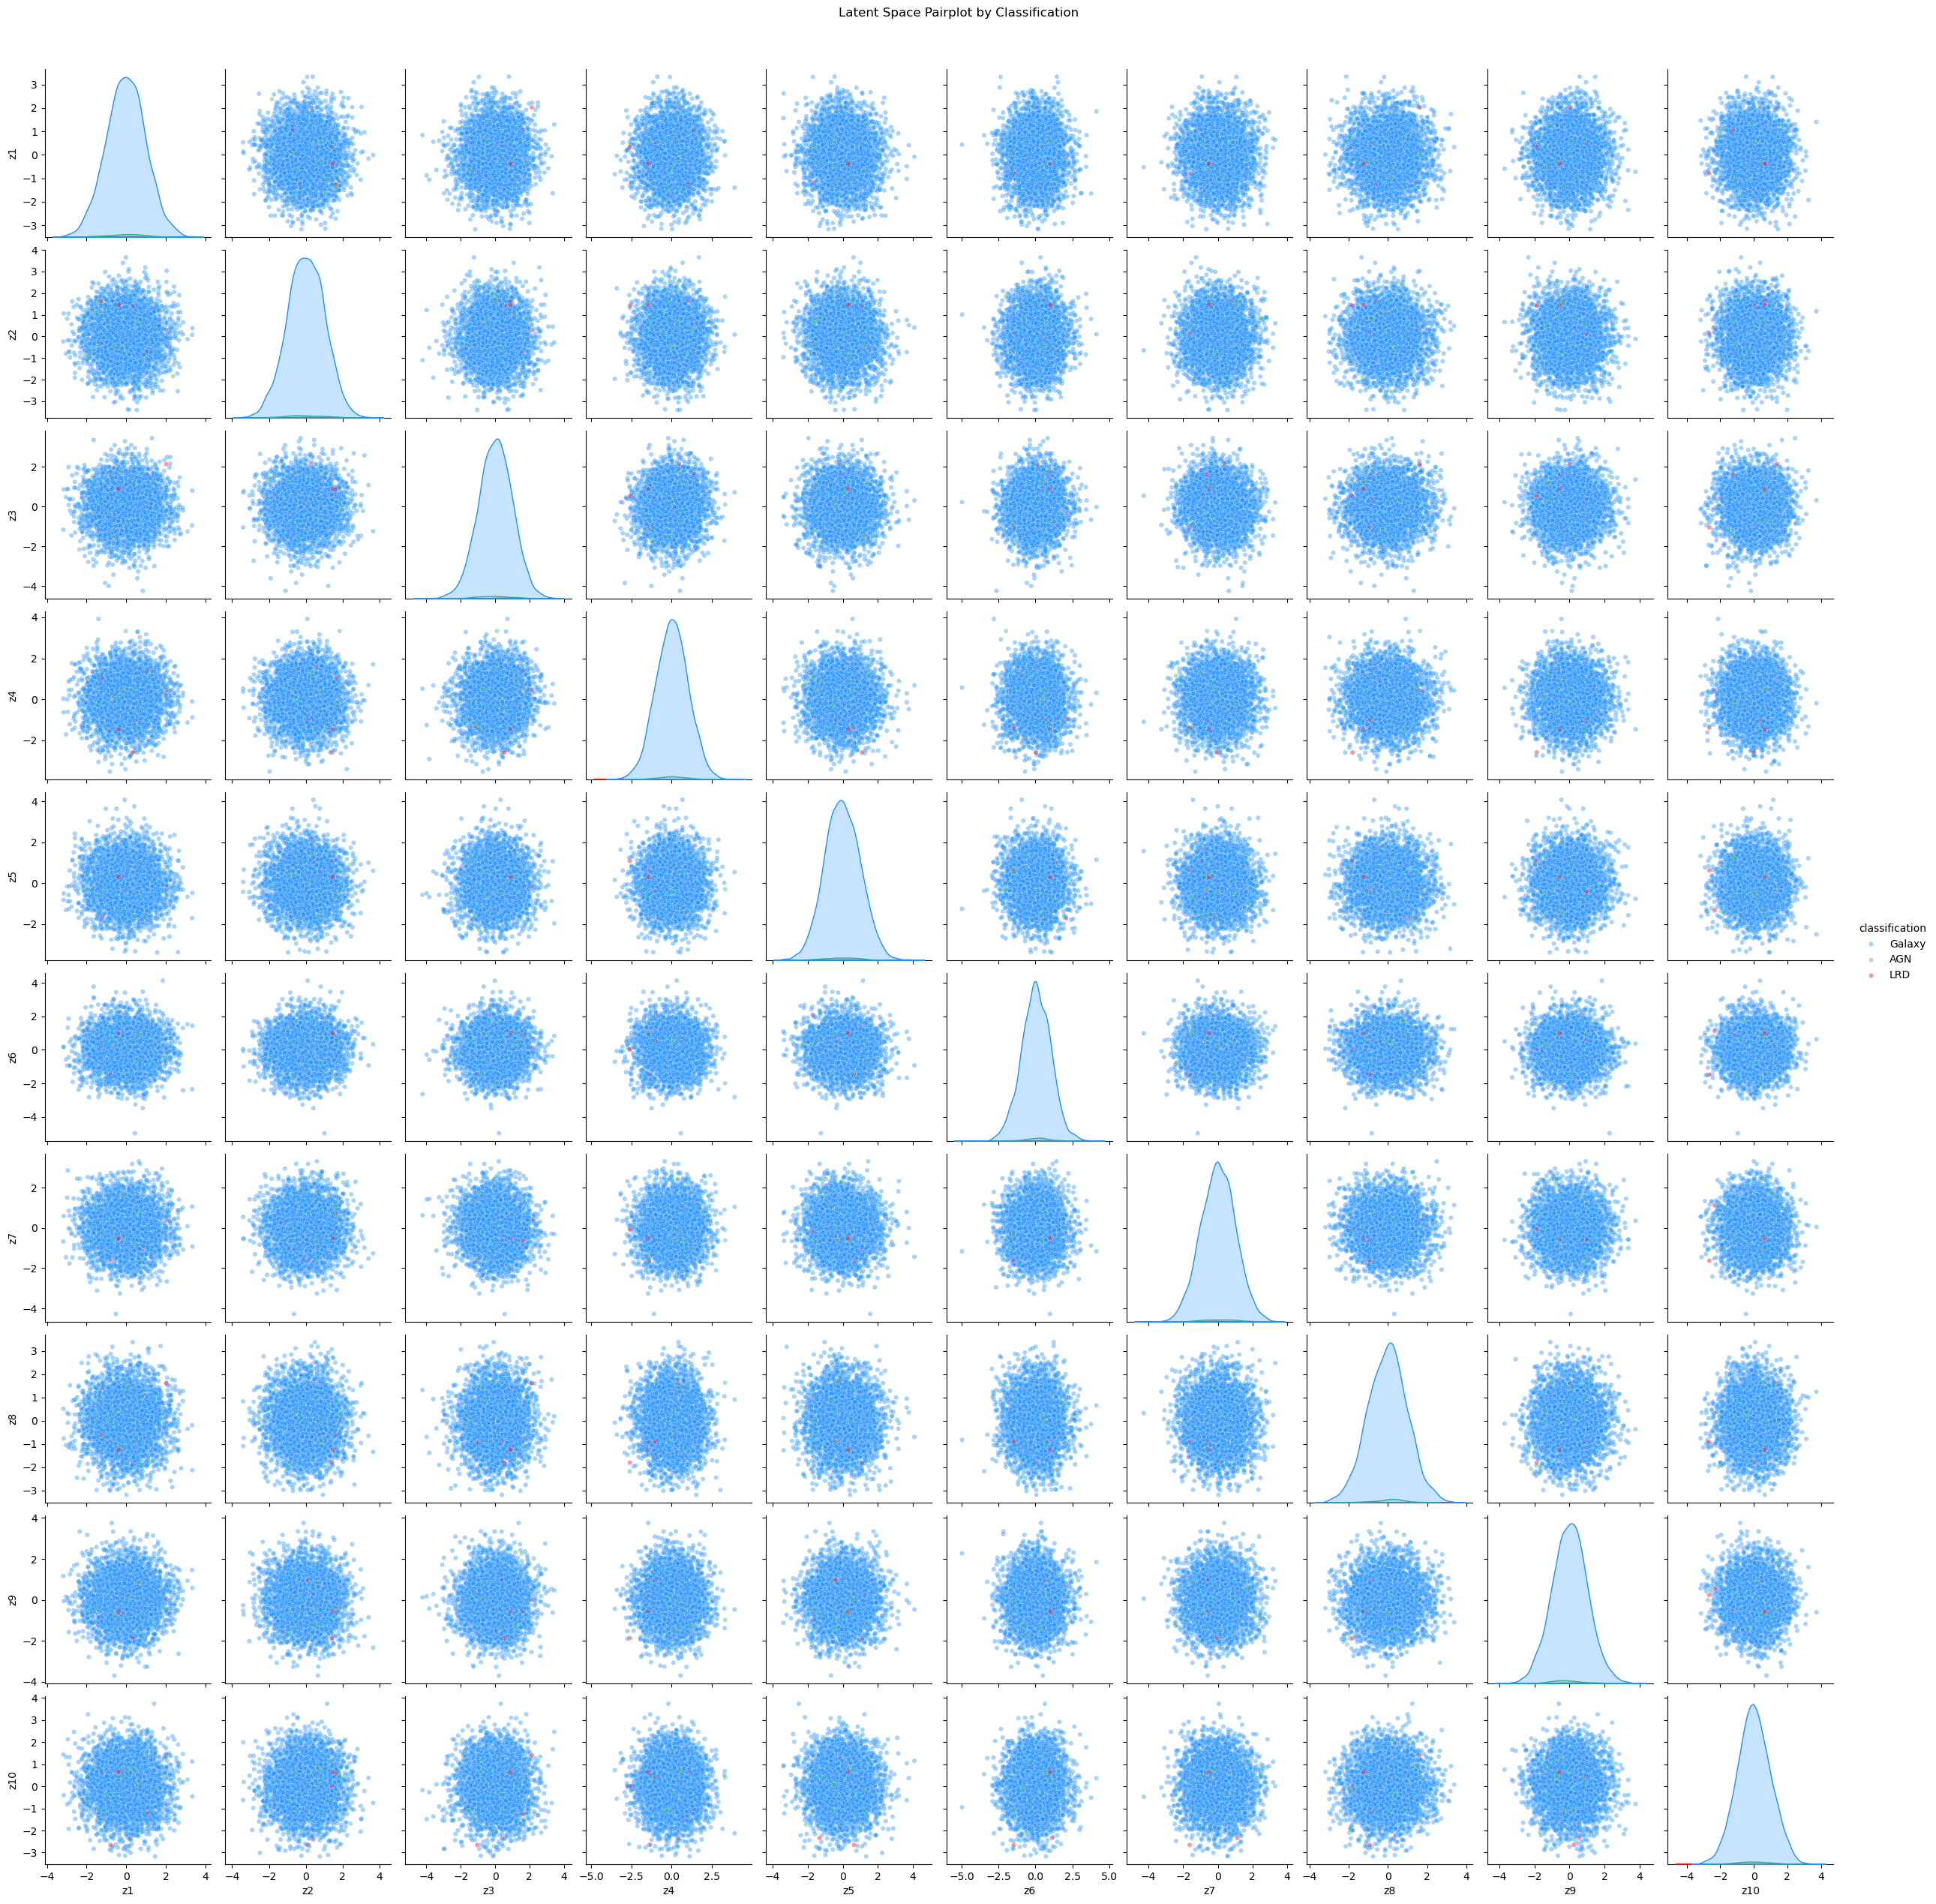

In [31]:
# Extract classification labels
labels = df_merged["classification"].to_numpy()

# Create visualization
LatentSpace_pairplot(encoder, [images, redshifts], labels)

### UMAP

We use Uniform Manifold Approximation and Projection (UMAP) to reduce the dimensionality of the latent space to a 3D projection while preserving both the global structure (overall shape of the data) and local structure (how nearby points relate to each other).

In [33]:
# if you don't have umap
# !pip install umap-learn

In [34]:
import umap
reducer = umap.UMAP(
    n_neighbors=15,      # local neighborhood size
    min_dist=0.1,        # how tightly UMAP packs points
    n_components=3,      # output dimensions (2D or 3D)
    metric='euclidean')   # distance metric

latent_space = encoder.predict([images, redshifts])

141/141 ━━━━━━━━━━━━━━━━━━━━ 18s 124ms/step


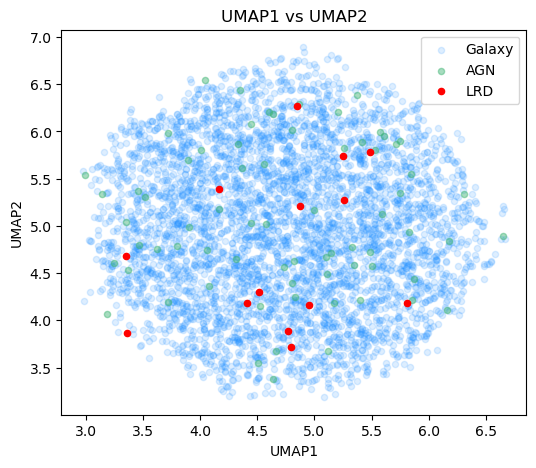

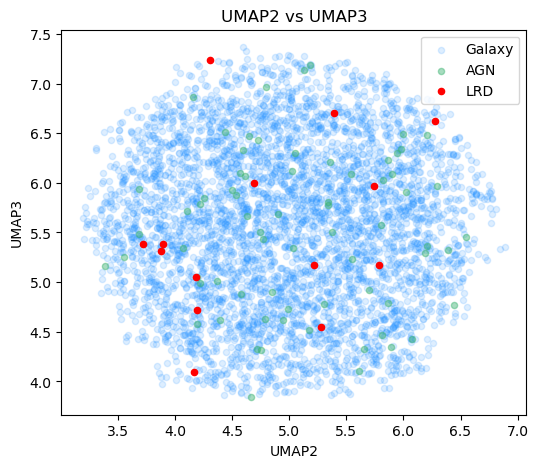

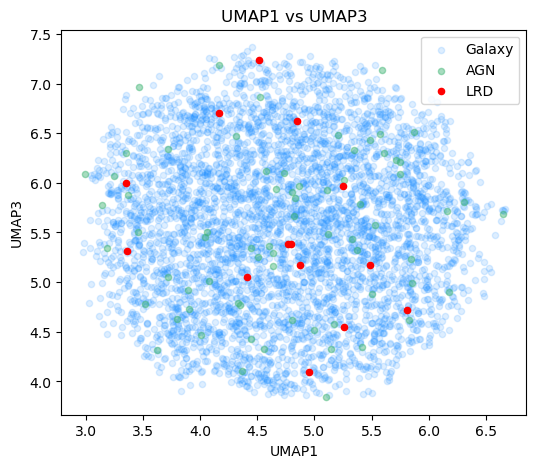

In [35]:
# create reduced dimension latent space
latent_umap = reducer.fit_transform(latent_space)
latent_dims = ['UMAP1', 'UMAP2', 'UMAP3']

df_latent = pd.DataFrame(latent_umap, columns=latent_dims)
df_latent['classification'] = df_merged['classification']

# color + alpha mapping to highlight LRDs
label_to_color = {"LRD": "red", "Galaxy": "dodgerblue", "AGN": "mediumseagreen"}
label_to_alpha = {"LRD": 1.0, "Galaxy": 0.15, "AGN": 0.45}

# pairwise plots 
plot_pairs = [('UMAP1', 'UMAP2'), ('UMAP2', 'UMAP3'), ('UMAP1', 'UMAP3')]

for x_dim, y_dim in plot_pairs:
    plt.figure(figsize=(6, 5))
    
    for cls in df_latent['classification'].unique():
        subset = df_latent[df_latent['classification'] == cls]
        plt.scatter(subset[x_dim], subset[y_dim],
                    color=label_to_color[cls],
                    alpha=label_to_alpha[cls],
                    label=cls,
                    s=20)
    
    plt.xlabel(x_dim)
    plt.ylabel(y_dim)
    plt.legend()
    plt.title(f"{x_dim} vs {y_dim}")
    plt.show()

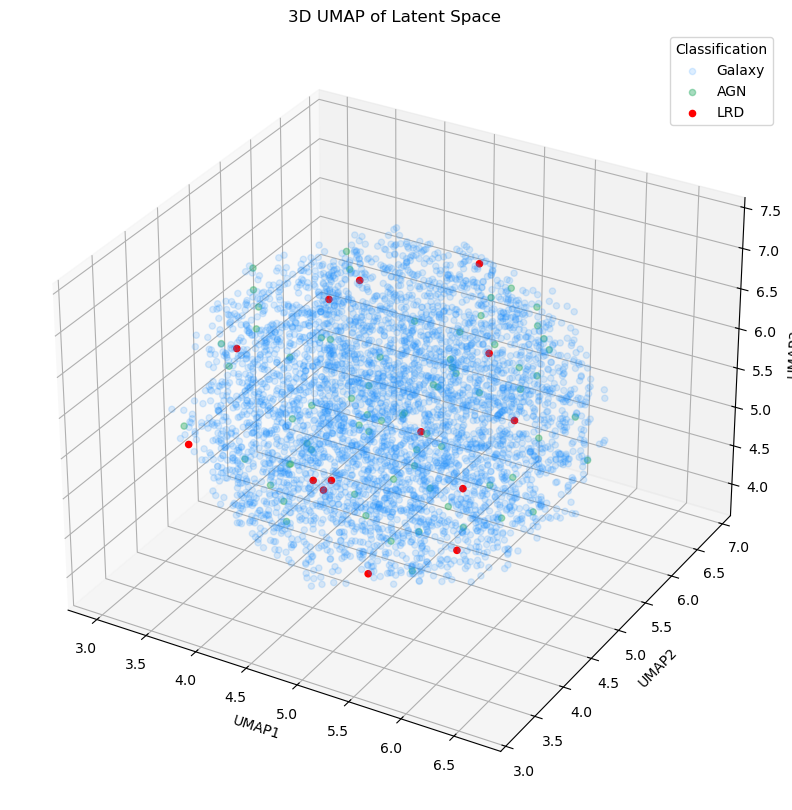

In [36]:
# 3D plot to see latent dimensions at once
from mpl_toolkits.mplot3d import Axes3D

# create figure and 3D axes
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# plot for each classification to maintain different alpha levels
for cls in df_latent['classification'].unique():
    subset = df_latent[df_latent['classification'] == cls]
    ax.scatter(subset['UMAP1'], subset['UMAP2'], subset['UMAP3'],
                   c=label_to_color[cls],
                   alpha=label_to_alpha[cls],
                   label=cls,
                   s=20)
    
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')
ax.legend(title = 'Classification')
ax.set_title('3D UMAP of Latent Space')

plt.show()

## Compare latent space distances

In [38]:
from scipy.spatial.distance import cdist

# Make data frames for separate classes
latent_LRD = df_latent[df_latent['classification'] == 'LRD'][['UMAP1','UMAP2','UMAP3']].values
latent_Galaxy = df_latent[df_latent['classification'] == 'Galaxy'][['UMAP1','UMAP2','UMAP3']].values
latent_AGN = df_latent[df_latent['classification'] == 'AGN'][['UMAP1','UMAP2','UMAP3']].values

# Euclidean distances from each LRD to every point in the other groups
dist_LRD_Galaxy = cdist(latent_LRD, latent_Galaxy)
dist_LRD_AGN = cdist(latent_LRD, latent_AGN)

# For each LRD, keep the nearest distance to each group
df_LRD = df_latent[df_latent['classification'] == 'LRD'].copy()
df_LRD['nearest_galaxy'] = dist_LRD_Galaxy.min(axis=1)
df_LRD['nearest_agn'] = dist_LRD_AGN.min(axis=1)

# Summary statistics
summary_panel = df_LRD[['nearest_galaxy', 'nearest_agn']].describe(percentiles=[.25, .5, .75]).T
summary_panel.rename(columns={
    '25%': 'Q1',
    '50%': 'Median',
    '75%': 'Q3'}, inplace=True)
summary_panel = summary_panel[['min','Q1','Median','Q3','max','mean','std']]

print(summary_panel)

                     min        Q1    Median        Q3       max      mean  \
nearest_galaxy  0.055385  0.084392  0.103958  0.118603  0.221094  0.106330   
nearest_agn     0.104845  0.284329  0.387042  0.416571  0.533198  0.355737   

                     std  
nearest_galaxy  0.038855  
nearest_agn     0.127913  


LRDs are closer to galaxies! Then again, there are more galaxies than AGNs in the raw data.